In [12]:
# https://github.com/BitMEX/api-connectors/tree/master/official-ws/python

In [16]:
import websocket
import sys
sys.path.append('/Users/luigibungaro/anaconda3/lib/python3.7/site-packages/')

In [ ]:
import websocket
#from bitmex_websocket import BitMEXWebsocket
ws = BitMEXWebsocket(endpoint="https://testnet.bitmex.com/api/v1", 
                     symbol="XBTUSD", 
                     api_key='6X2pkSmIEegos7tXbspQwRrA', 
                     api_secret='lSzoW5lGxcIfojZbvIMfi8wyt4E5vzMB3z16Dsx78JKb4Kwj')

# Working with Kaggle Data

In [30]:
# https://www.kaggle.com/smitad/bitcoin-trading-strategy-simulation

# https://bigpicture.typepad.com/comments/files/turtlerules.pdf

In [32]:
import numpy as np 
import pandas as pd 
import datetime

In [33]:
!pwd

/Users/luigibungaro/A_Python_Projects


In [34]:
df = pd.read_csv('bitstamp_usd.csv')
print(df.shape)
df.head()

(3603136, 8)


,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
df.isnull().sum()

Timestamp                  0
Open                 1214307
High                 1214307
Low                  1214307
Close                1214307
Volume_(BTC)         1214307
Volume_(Currency)    1214307
Weighted_Price       1214307
dtype: int64

In [36]:
df['Volume_(BTC)'].fillna(value=0, inplace=True)
df['Volume_(Currency)'].fillna(value=0, inplace=True)
df['Weighted_Price'].fillna(value=0, inplace=True)

In [37]:
df['Open'].fillna(method='ffill', inplace=True)
df['High'].fillna(method='ffill', inplace=True)
df['Low'].fillna(method='ffill', inplace=True)
df['Close'].fillna(method='ffill', inplace=True)

In [42]:
signal_lookback = 60 * 24 * 60 # days * hours * minutes --> we are looking back of 60 days

# here's our signal columns
df['Buy'] = np.zeros(len(df))
df['Sell'] = np.zeros(len(df))

In [43]:
df.head(2)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Buy,Sell
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,0.0,0.0
1,1325317980,4.39,4.39,4.39,4.39,0.000000,0.0,0.00,0.0,0.0


In [48]:
# this is our 'working out', you could collapse these into the .loc call later on and save memory 
# but I've left them in for debug purposes, makes it easier to see what is going on
df['RollingMax'] = df['Close'].shift(1).rolling(signal_lookback, min_periods=signal_lookback).max()
df['RollingMin'] = df['Close'].shift(1).rolling(signal_lookback, min_periods=signal_lookback).min()
df.tail(5)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Buy,Sell,RollingMax,RollingMin
3603131,1541894100,6348.54,6348.54,6348.54,6348.54,0.007997,50.769274,6348.540000,0.0,0.0,6815.01,6068.11
3603132,1541894160,6348.54,6349.01,6348.54,6349.01,0.011729,74.466671,6348.936090,0.0,0.0,6815.01,6068.11
3603133,1541894220,6349.01,6349.01,6349.01,6349.01,0.068436,434.503642,6349.010000,0.0,0.0,6815.01,6068.11
3603134,1541894280,6349.01,6349.01,6349.01,6349.01,0.000000,0.000000,0.000000,0.0,0.0,6815.01,6068.11
3603135,1541894340,6349.17,6349.32,6349.17,6349.32,0.038261,242.927410,6349.214148,0.0,0.0,6815.01,6068.11


In [52]:
df.loc[df['RollingMax'] < df['Close'], 'Buy'] = 1
df.loc[df['RollingMin'] > df['Close'], 'Sell'] = -1
df.head(2)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Buy,Sell,RollingMax,RollingMin
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,0.0,0.0,NaN,NaN
1,1325317980,4.39,4.39,4.39,4.39,0.000000,0.0,0.00,0.0,0.0,NaN,NaN


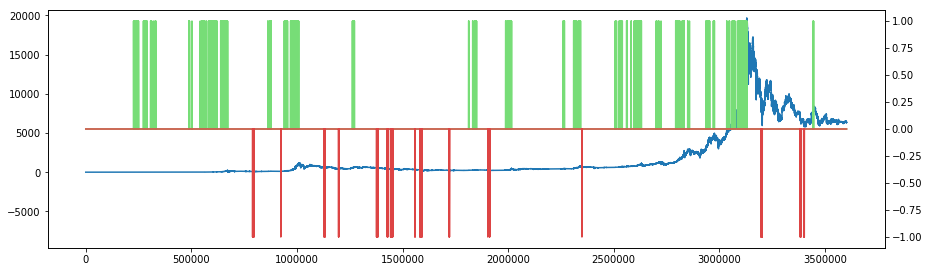

In [62]:
# lets now take a look and see if its doing something sensible
import matplotlib
import matplotlib.pyplot as plt


fig,ax1 = plt.subplots(1,1,figsize=(15,15))
ax1.plot(df['Close'])
y = ax1.get_ylim()
ax1.set_ylim(y[0] - (y[1]-y[0])*0.4, y[1])

ax2 = ax1.twinx()
ax2.set_position(matplotlib.transforms.Bbox([[0.125,0.1],[0.9,0.32]]))
ax2.plot(df['Buy'], color='#77dd77')
ax2.plot(df['Sell'], color='#dd4444')

# Approach with LSTM

In [64]:
# https://www.kaggle.com/zikazika/using-rnn-and-arima-to-predict-bitcoin-price